In [1]:
from scipy import signal

def buffer_nans(da, kn):
    k = np.zeros((kn,kn))
    k[kn//2,kn//2] = 1

    arr = da.values
    mask = np.ones(arr.shape).astype(np.float32)

    for i in range(arr.shape[0]):
        mask[i,:,:] = signal.convolve2d(arr[i,:,:], k, boundary='fill', mode='same')

    return da.where(~np.isnan(mask))

In [14]:
ds2018 = xr.open_dataset("/data/pca_act/000_2018.nc")
ds2019 = xr.open_dataset("/data/pca_act/000_2019.nc")

ds = xr.concat([ds2018, ds2019], dim='time').sortby('time')

ds

<xarray.Dataset>
Dimensions:       (time: 129, x: 400, y: 400)
Coordinates:
    spatial_ref   int32 -2147483647
  * y             (y) float64 -3.933e+06 -3.933e+06 ... -3.937e+06 -3.937e+06
  * x             (x) float64 1.507e+06 1.507e+06 ... 1.511e+06 1.511e+06
  * time          (time) datetime64[ns] 2018-01-03T00:11:01 ... 2019-12-04T00:11:11
Data variables:
    nbart_red     (time, y, x) float32 4025.0 4176.0 4585.0 ... 628.0 666.0
    nbart_green   (time, y, x) float32 3795.0 4173.0 4584.0 ... 507.0 517.0
    nbart_blue    (time, y, x) float32 3907.0 4351.0 4539.0 ... 353.0 379.0
    nbart_nir_1   (time, y, x) float32 4921.0 5441.0 5695.0 ... 1729.0 1697.0
    nbart_nir_2   (time, y, x) float32 5078.0 5078.0 5712.0 ... 1815.0 1815.0
    nbart_swir_2  (time, y, x) float32 4435.0 4435.0 5088.0 ... 2113.0 2113.0
    nbart_swir_3  (time, y, x) float32 3690.0 3690.0 4342.0 ... 1400.0 1400.0
Attributes:
    date_created:           2020-09-22T12:05:16.578111
    Conventions:            C

In [36]:
blue = ds[band_name].astype(np.float32) / 1e4
# 1.- Filter reflectances greater than 0.5 
blue = blue.where(blue<.4)

# 2.- Filter reflectances with difference to lower quartile larger than 0.05 => (0.07)
#blue = blue.where((blue - blue.quantile(0.25, dim='time'))<.05)


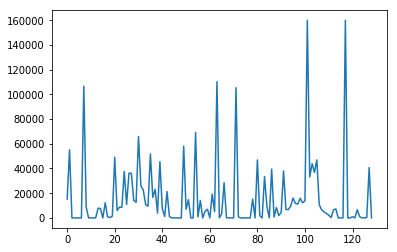

In [46]:
%matplotlib inline

np.count_nonzero(np.isnan(blue.isel(time=-2)))


plt.plot(np.count_nonzero(np.isnan(blue),axis=(1,2)))

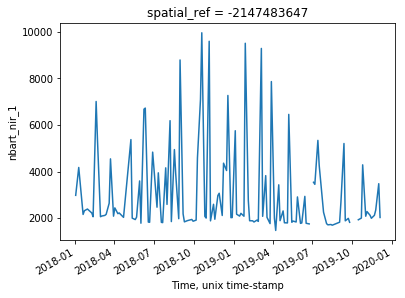

In [51]:
ds.nbart_nir_1.mean(dim=("x","y")).plot()

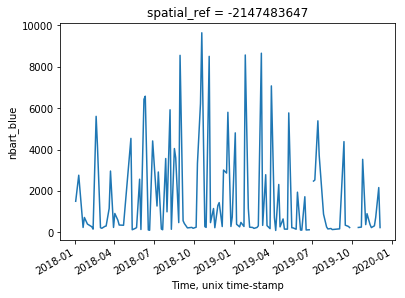

In [52]:
ds.nbart_blue.mean(dim=("x","y")).plot()

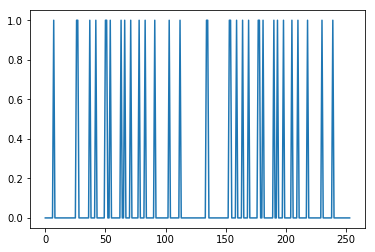

In [58]:
from sklearn.cluster import KMeans

X1 = ds.nbart_blue.isel(x=100,y=100).values
X2 = ds.nbart_nir_1.isel(x=100,y=100).values
X = np.hstack((X1,X2))
X = X[~np.isnan(X)]

kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(-1,1))

kmeans.labels_, kmeans.cluster_centers_

plt.plot(kmeans.labels_)

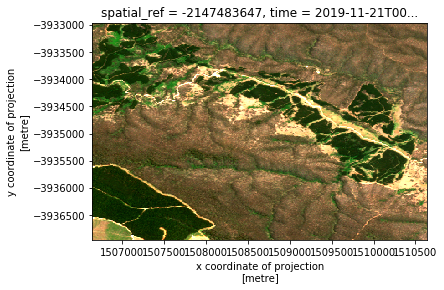

In [38]:
ds[['nbart_red','nbart_green','nbart_blue']].where(~np.isnan(blue)).isel(time=-4).to_array().plot.imshow(robust=True)

/home/pl5189/.local/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


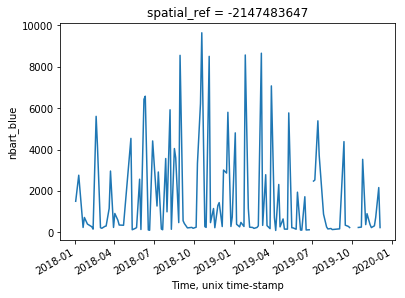

In [49]:
ds.nbart_blue.mean(dim=("x","y")).plot()

In [10]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

ds2018 = xr.open_dataset("/data/pca_act/000_2018.nc")
ds2019 = xr.open_dataset("/data/pca_act/000_2019.nc")

ds = xr.concat([ds2018, ds2019], dim='time').sortby('time')

blue = ds[band_name].astype(np.float32) / 1e4
# 1.- Filter reflectances greater than 0.5 
blue = blue.where(blue<.5)

# 2.- Filter reflectances with difference to lower quartile larger than 0.05 => (0.07)
blue = blue.where((blue - blue.quantile(0.25, dim='time'))<.07)

# 3.- Grow a 5x5 buffer around NaN pixels 
blue = buffer_nans(blue, 5)

# 4.- Discard frames with more than 25% missing pixels
blue = blue.isel(time=(blue.count(dim=('x','y'))/(400*400))>.25)


stack = np.empty((0,400,400))

for band_name in ds:
    
    band = ds[band_name].astype(np.float32) / 1e4
    
    # 1. Apply blue mask
    band = band.sel(time=blue.time).where(~np.isnan(blue))

    # 2.- Interpolate NaNs over time linearly
    band = band.interpolate_na(dim='time')

    # 3.- Interpolate NaNs at the start and end using nearest neighbor
    band = band.interpolate_na(dim='time', method='nearest', fill_value='extrapolate')

    # 4.- Apply median rolling filter along time (window=3)
    band = band.rolling(time=3, min_periods=1).median()
    
    stack = np.append(stack, band, axis=0)
    
    print(stack.shape)

(94, 400, 400)
(188, 400, 400)
(282, 400, 400)
(376, 400, 400)
(470, 400, 400)
(564, 400, 400)
(658, 400, 400)


In [11]:
from sklearn.decomposition import PCA
    
stack = stack.reshape(stack.shape[0], -1)

pca = PCA().fit(stack)
coeffs = pca.transform(stack)
pcs = pca.components_.reshape(-1,400,400)
mean = pca.mean_.reshape(-1,400,400)

stack.shape

(658, 160000)

In [13]:
from ipywidgets import interactive
import ipywidgets as widgets
    
def plot_rgb(t, n):
    red_rec = np.copy(pca.mean_.reshape((400,400)))
    green_rec = np.copy(pca.mean_.reshape((400,400)))
    blue_rec = np.copy(pca.mean_.reshape((400,400)))
    
    for n_pc in range(n):
        red_rec += coeffs[t,n_pc] * pcs[n_pc]
        green_rec += coeffs[94+t,n_pc] * pcs[n_pc]
        blue_rec += coeffs[188+t,n_pc] * pcs[n_pc]
        
    f, axarr = plt.subplots(1, 2, figsize=(12,6))

    rec_rgb = np.dstack((red_rec,green_rec,blue_rec))
    rgb = np.dstack((stack[t],stack[94+t],stack[188+t])).reshape(400,400,3)
    
    axarr[0].imshow(3*rgb)
    axarr[1].imshow(3*rec_rgb)

interactive_plot = interactive(plot_rgb, 
                               t=widgets.IntSlider(min=0, max=105, step=1, 
                                                   value=0, continuous_update=False),
                               n=widgets.IntSlider(min=0, max=20, step=1, 
                                                   value=20, continuous_update=False))
output = interactive_plot.children[-1]
output.layout.height = '350px'

interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=105), IntSlider(value=2…

### Decompose original data using 20 PCs

In [31]:
pca = PCA(n_components=20).fit(stack)
stackT = pca.transform(stack)

stackT.shape

(735, 20)

### Regenerate initial data using the decomposed components

In [32]:
rec_stack = pca.inverse_transform(stackT)

rec_stack.shape

(735, 160000)

### Write video comparing RGB time series of the original data (left) and recreated PCA (right)

In [37]:
import imageio

writer = imageio.get_writer('video.mp4', fps=2)

for t in range(105):
    orig_r = stack[0*105+t].reshape((400,400))
    rec_r = rec_stack[0*105+t].reshape((400,400))
    orig_g = stack[1*105+t].reshape((400,400))
    rec_g = rec_stack[1*105+t].reshape((400,400))
    orig_b = stack[2*105+t].reshape((400,400))
    rec_b = rec_stack[2*105+t].reshape((400,400))
    
    writer.append_data(3*np.concatenate((np.dstack((orig_r,orig_g,orig_b)),np.dstack((rec_r,rec_g,rec_b))), axis=1))

writer.close()

In [34]:
from IPython.display import Video

Video("video.mp4")

In [9]:
coefs = pca.transform(stack)
comps = pca.components_

def plot_img(band, t):     
    f, axarr = plt.subplots(1,2)
    orig = stack[band*105+t].reshape((400,400))
    rec = rec_stack[band*105+t].reshape((400,400))
    
    axarr[0].imshow(orig, vmin=0, vmax=orig.max())
    axarr[1].imshow(rec, vmin=0, vmax=orig.max())
    
    print(orig.max(), rec.max())
    
def plot_rgb(t):     
    f, axarr = plt.subplots(1,2)
    
    orig_r = stack[0*105+t].reshape((400,400))
    rec_r = rec_stack[0*105+t].reshape((400,400))
    orig_g = stack[1*105+t].reshape((400,400))
    rec_g = rec_stack[1*105+t].reshape((400,400))
    orig_b = stack[2*105+t].reshape((400,400))
    rec_b = rec_stack[2*105+t].reshape((400,400))
    
    axarr[0].imshow(np.dstack((orig_r,orig_g,orig_b))*3)
    axarr[1].imshow(np.dstack((rec_r,rec_g,rec_b))*3)